# **Revisão Teórica**





# Controlador Proporcional
Função de transferência do controlador, 

$$G_c (s) = \frac{U(s)}{E(s)} = K_p $$

Logo o sinal de controle é proporcional ao erro de controle.

No domínio de tempo discreto, temos, 

$$u(k) = K_p e(k)$$.

Lembre-se de que o controlador foi projetado para um ponto de operação, logo para calcular o erro de contorle, deve remover o valor correspondente ao ponto de operação na saída, 

$y(k)$ = sinal_medido - valor_ponto_operação
$$e(k) = r(k) - y(k)$$




In [1]:
# !pip install pyserial 

In [6]:
"""
Bancada Motor-Gerador
UFPA - Campus Tucuruí
Monitoria de Sistemas de Controle para Engenharia - PGRAD - MONITORIA 03/2020
Coodenador: Cleison Daniel Silva
Bolsista: Felipe Silveira Piano
Data: 27/09/2020
"""

# from pyserial import Serial
import numpy as np
import matplotlib.pyplot as plt
import time as t
from scipy.signal import square,sawtooth
import serial

##########################################
# Tensão de alimentação da bancada
amplitude_maxima = 15

numAmostras = 400
tempo = np.zeros(numAmostras)
y = np.zeros(numAmostras)

Ts = 0.02

fre = 0.5
Amplitude = 0.5
ponto_de_operacao = 7.5

nivel_dc_saida = 2.266


#a = 2*np.ones(int(numAmostras/2))
#b = 4*np.ones(int(numAmostras/2))
#u = np.concatenate([a,b]) #degrau
r = np.zeros(numAmostras)
u = np.zeros(numAmostras)

toc = np.zeros(numAmostras)
######################


for n in range(numAmostras):
    r[n] = Amplitude*square(2*np.pi*fre*n*Ts) + ponto_de_operacao
    #r[n] = Amplitude*sawtooth(2*np.pi*fre*n*Ts) + setpoint
    #r[n] = Amplitude*np.sin(2*np.pi*fre*n*Ts) + setpoint
    #r[n] = u[n]
    
# print('\nEstabelecendo conexão.')
# conexao = serial.Serial(port='COM5', baudrate=9600, timeout=0.005)

t.sleep(1)
print('\nIniciando coleta.')

print('\nEstabelecendo conexão.')
# conexao = serial.Serial(port='/dev/ttyACM0', baudrate=9600, timeout=0.005)
conexao = serial.Serial(port='COM8', baudrate=9600, timeout=0.005)

##_____________ Loop principal de controle _____________##
nivel_dc_entrada = ponto_de_operacao
Kp =  2.296
for n in range(numAmostras):
    tic = t.time()

    if (conexao.inWaiting() > 0):
        y[n] = conexao.readline().decode()

    # remove o nivel_dc_saida
    sinal_medido = y[n] - nivel_dc_saida
    
    # calcula o erro
    e = r[n] - sinal_medido

    # primeiras 50 amostras
    if (n<50):
      u[n] = nivel_dc_entrada
      r[n] = 0.0
    else:
      u[n] = (Kp*e) + nivel_dc_entrada

    if (u[n] > amplitude_maxima):
      sinal_PWM = 255
    else:
      sinal_PWM = ((u[n])*255)/amplitude_maxima

    # sinal_PWM deve ser um número inteiro entre 0 e 255  
    conexao.write(str(round(sinal_PWM)).encode())
    
    t.sleep(Ts)
    
    if (n > 0):
        tempo[n] = tempo[n-1] + Ts
    toc[n] = t.time() - tic


Iniciando coleta.

Estabelecendo conexão.


In [ ]:
!pip install control -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
import control as ct

Kc = 3.57
a = -24

Gc = ct.tf([Kc*1,Kc*a],[1,0])

# Controlador PI

Função de Transferência de Controlador PI:

$$ G_c (s) = \frac{K_c (s + a)}{s} \tag{B}$$

Discretização para $T_s$, período de amostragem. 

1. Forward Differences
$$G_c(z) = G_c(s)|_{s = \frac{z - 1}{T_s}}$$
2. Backwards Differences
$$G_c(z) = G_c(s)|_{s = \frac{1}{T_s} \frac{z - 1}{z}}$$
3. Trapezoidal (Tustin)
  $$G_c(z) = G_c(s)|_{s = \frac{2}{T_s} \frac{z - 1}{z + 1}}$$

No domínio $z$, temos, 
$$\frac{U(z)}{E(z)} = \frac{b_0 z + b_1}{z - 1} \frac{z^{-1}}{z^{-1}} $$


no tempo discreto, a Equação de Diferenças:

$$ u(k) = u(k-1) + b_0 e(k) + b_1 e(k-1)$$ 


In [ ]:
Gz = ct.c2d(Gc,Ts, 'tustin')

print('Função de Transferência do controlador: \n', Gz)

Função de Transferência do controlador: 
 
2.713 z - 4.427
---------------
     z - 1

dt = 0.02



In [ ]:
"""
Bancada Motor-Gerador
UFPA - Campus Tucuruí
Monitoria de Sistemas de Controle para Engenharia - PGRAD - MONITORIA 03/2020
Coodenador: Cleison Daniel Silva
Bolsista: Felipe Silveira Piano
Data: 27/09/2020
"""

from pyserial import Serial
import numpy as np
import matplotlib.pyplot as plt
import time as t
from scipy.signal import square,sawtooth


##########################################
# Tensão de alimentação da bancada
amplitude_maxima = 15

numAmostras = 400
tempo = np.zeros(numAmostras)
y = np.zeros(numAmostras)

Ts = 0.02

fre = 0.5
Amplitude = 0.5
ponto_de_operacao = 0

nivel_dc_saida = 1.5


#a = 2*np.ones(int(numAmostras/2))
#b = 4*np.ones(int(numAmostras/2))
#u = np.concatenate([a,b]) #degrau
r = np.zeros(numAmostras)
u = np.zeros(numAmostras)
delta_u = np.zeros(numAmostras)

toc = np.zeros(numAmostras)
######################


for n in range(numAmostras):
    r[n] = Amplitude*square(2*np.pi*fre*n*Ts) + ponto_de_operacao
    #r[n] = Amplitude*sawtooth(2*np.pi*fre*n*Ts) + setpoint
    #r[n] = Amplitude*np.sin(2*np.pi*fre*n*Ts) + setpoint
    #r[n] = u[n]
    
print('\nEstabelecendo conexão.')
conexao = serial.Serial(port='COM5', baudrate=9600, timeout=0.005)

t.sleep(1)
print('\nIniciando coleta.')

##_____________ Loop principal de controle _____________##
nivel_dc_entrada = ponto_de_operacao
Gz = ct.c2d(Gc,Ts, 'tustin')
b0 = Gz.num[0][0][0]
b1 = Gz.num[0][0][1]


for n in range(numAmostras):
    tic = t.time()

    if (conexao.inWaiting() > 0):
        y[n] = conexao.readline().decode()

    # remove o nivel_dc_saida
    sinal_medido = y[n] - nivel_dc_saida
    
    # calcula o erro
    e = r[n] - sinal_medido

    # primeiras 50 amostras
    if (n<50):
      u[n] = nivel_dc_entrada
      r[n] = 0.0
    else:
      delta_u[n] = delta_u[n-1] + b0*e[n] + b1*e[n-1]
      u[n] = nivel_dc_entrada + delta_u[n]   

    if (u[n] > amplitude_maxima):
      sinal_PWM = 255
    else:
      sinal_PWM = ((u[n])*255)/amplitude_maxima

    # sinal_PWM deve ser um número inteiro entre 0 e 255  
    conexao.write(str(round(sinal_PWM)).encode())
    
    t.sleep(Ts)
    
    if (n > 0):
        tempo[n] = tempo[n-1] + Ts
    toc[n] = t.time() - tic

# **Sinais Binários Pseudo-Aleatórios (PRBS)**

In [ ]:
def PRBS(size_min_seq, size):
  rand = np.random.randint(0,10,size=size)
  prbs = []
  for i in range(size):
    if rand[i] > 5:
      prbs.append(np.ones(size_min_seq))
    else:
      prbs.append(np.zeros(size_min_seq))
  prbs = np.array(prbs).reshape(size*size_min_seq)[0:size]
  return prbs

In [ ]:
prbs = PRBS(size_min_seq=2**3,size = 1024)
numAmostras = len(prbs)
r = np.zeros(numAmostras)

tempo = np.linspace(0,4,1024)

for n in range(numAmostras):
  r[n] = prbs[n]

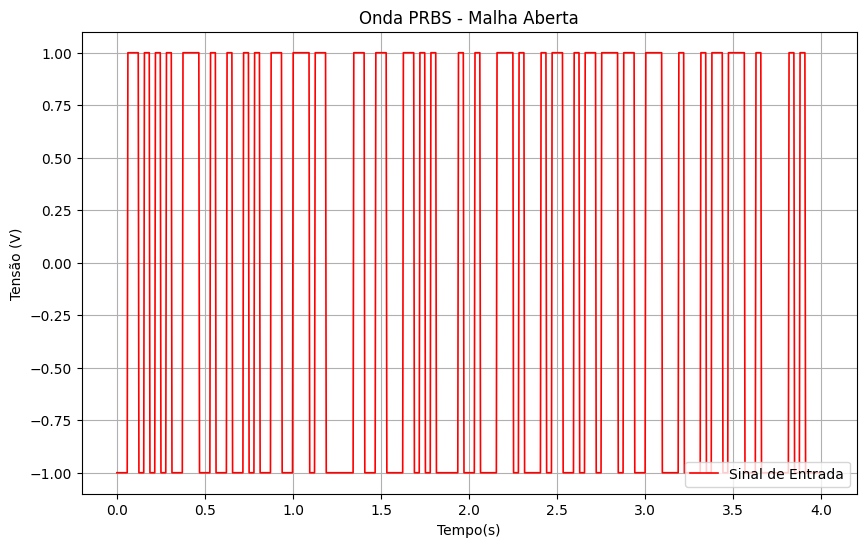

In [ ]:
plt.figure(figsize=(10,6))
# plt.plot(tempo,r,'-b',tempo,y,'-r',linewidth=1.2)
plt.plot(tempo,2*r-1, '-r', linewidth = 1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('Tensão (V)')
plt.grid()
plt.title('Onda PRBS - Malha Aberta')
plt.legend(loc='lower right', labels=('Sinal de Entrada','Sinal de Saída'))
plt.show()

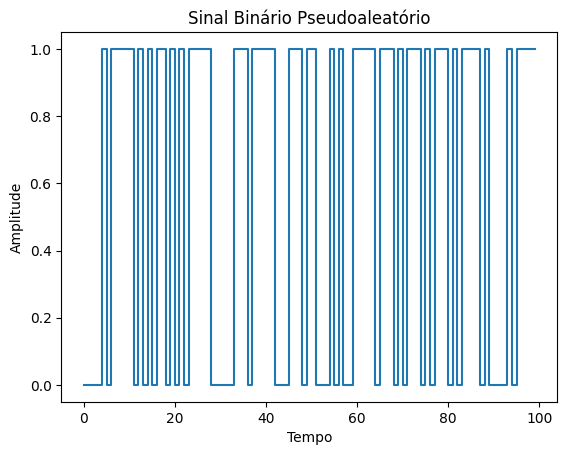

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho da sequência
n = 100

# Gera a sequência de bits aleatórios
bits = np.random.choice([0, 1], size=n)

# Cria um vetor de tempo
t = np.arange(n)

# Plota o sinal
plt.step(t, bits, where='post')
plt.xlabel('Tempo')
plt.ylabel('Amplitude')
plt.title('Sinal Binário Pseudoaleatório')
plt.show()

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


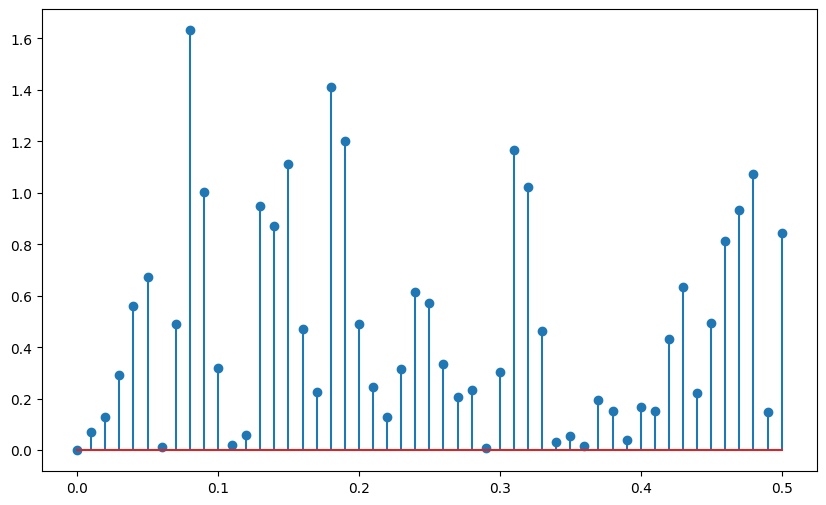

In [ ]:
from scipy.signal import square, sawtooth, correlate, welch
# f,p = welch(2*bits-1)
f,p = welch(bits)

plt.figure(figsize=(10,6))
plt.stem(f,p)
plt.show()